<a href="https://colab.research.google.com/github/NoCodeProgram/deepLearning/blob/main/nn/classification_b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/NoCodeProgram/deepLearning.git


Cloning into 'deepLearning'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 52 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (52/52), 1.66 MiB | 3.08 MiB/s, done.


In [2]:
import torch
import pandas as pd

# Load the DataFrame from a CSV file
df = pd.read_csv('./deepLearning/nn/classify5k.csv')

# Convert the DataFrame to a numpy array
data = df[['x', 'y']].values
labels = df['label'].values.reshape(-1, 1)

# Print the shapes of the data and labels
print(f'Data shape:{data.shape}')
print(f'Labels shape:{labels.shape}')


Data shape:(5000, 2)
Labels shape:(5000, 1)


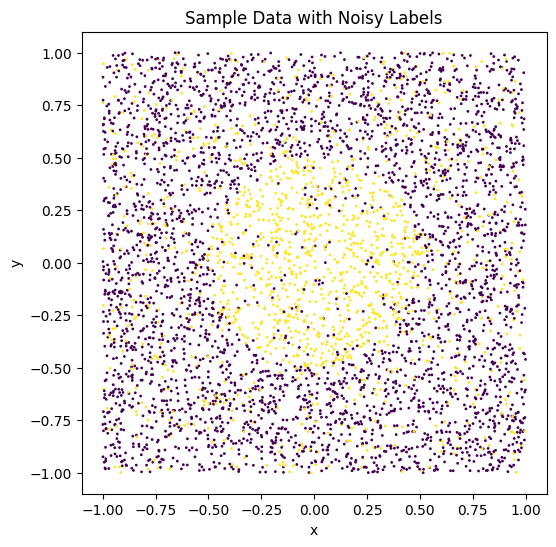

In [3]:
import matplotlib.pyplot as plt

# Plot the points
plt.figure(figsize=(6, 6))
plt.scatter(data[:,0], data[:,1], c=labels, cmap='viridis', s=1)
plt.title('Sample Data with Noisy Labels')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [4]:
# Convert the numpy arrays to PyTorch tensors
data_torch = torch.tensor(data, dtype=torch.float32)
labels_torch = torch.tensor(labels, dtype=torch.float32)
data_length = len(data_torch)
split_length = int(0.8*data_length)

train_data = data_torch[:split_length]
train_labels = labels_torch[:split_length]
val_data = data_torch[split_length:]
val_labels = labels_torch[split_length:]

print(train_data.shape, train_labels.shape)

torch.Size([4000, 2]) torch.Size([4000, 1])


In [5]:
g = torch.Generator().manual_seed(42)

def get_batch(data, labels, batch_size=16):
    # Generate random indices
    indices = torch.randint(0, len(data), size=(batch_size,), generator= g)

    # Select the data and labels at these indices
    data_batch = data[indices]
    labels_batch = labels[indices]

    return data_batch, labels_batch

data_batch, labels_batch = get_batch(train_data,train_labels)
print(data_batch.shape, labels_batch.shape)

torch.Size([16, 2]) torch.Size([16, 1])


In [6]:
import torch.nn.functional as F

input_size = 2
hidden_size = 4
output_size = 1

g.manual_seed(42)
W1 = torch.randn((input_size, hidden_size), generator=g)
b1 = torch.randn(hidden_size, generator=g)
W2 = torch.randn((hidden_size, output_size) , generator=g)
b2 = torch.randn(output_size, generator=g)
params = [W1,b1,W2,b2]
for p in params:
    p.requires_grad = True

for steps in range(200000):
    data_batch, labels_batch = get_batch(train_data,train_labels, batch_size=256)
    tmp = data_batch@W1 + b1
    tmp = F.relu(tmp)
    output = tmp@W2 + b2
    output = torch.sigmoid(output)
    loss = -1 * (labels_batch * torch.log(output) + (1 - labels_batch) * torch.log(1 - output)).mean()

    grad = loss.backward()
    with torch.no_grad():
        W1 -= 0.01 * W1.grad
        b1 -= 0.01 * b1.grad
        W2 -= 0.01 * W2.grad
        b2 -= 0.01 * b2.grad
        W1.grad.zero_()
        b1.grad.zero_()
        W2.grad.zero_()
        b2.grad.zero_()

    if steps % 1000 == 0:
        tmp = val_data@W1 + b1
        tmp = F.relu(tmp)
        output = tmp@W2 + b2
        prop = torch.sigmoid(output)
        val_loss = -1 * (val_labels * torch.log(prop) + (1 - val_labels) * torch.log(1 - prop)).mean()
        print(f"{steps},val_loss: {val_loss},train_loss: {loss}" )



0,val_loss: 1.3978241682052612,train_loss: 1.4936147928237915
1000,val_loss: 0.5771786570549011,train_loss: 0.5657188296318054
2000,val_loss: 0.5651401877403259,train_loss: 0.5574727058410645
3000,val_loss: 0.557136058807373,train_loss: 0.6026073098182678
4000,val_loss: 0.5546523332595825,train_loss: 0.5503630638122559
5000,val_loss: 0.5533393025398254,train_loss: 0.5209324955940247
6000,val_loss: 0.5530704855918884,train_loss: 0.5149208903312683
7000,val_loss: 0.553116500377655,train_loss: 0.5240189433097839
8000,val_loss: 0.5529383420944214,train_loss: 0.6264333128929138
9000,val_loss: 0.5529107451438904,train_loss: 0.5353437662124634
10000,val_loss: 0.5529548525810242,train_loss: 0.5514947175979614
11000,val_loss: 0.5529171228408813,train_loss: 0.5856175422668457
12000,val_loss: 0.5530015230178833,train_loss: 0.518651008605957
13000,val_loss: 0.5529580116271973,train_loss: 0.5643130540847778
14000,val_loss: 0.5529147982597351,train_loss: 0.507625162601471
15000,val_loss: 0.552678167

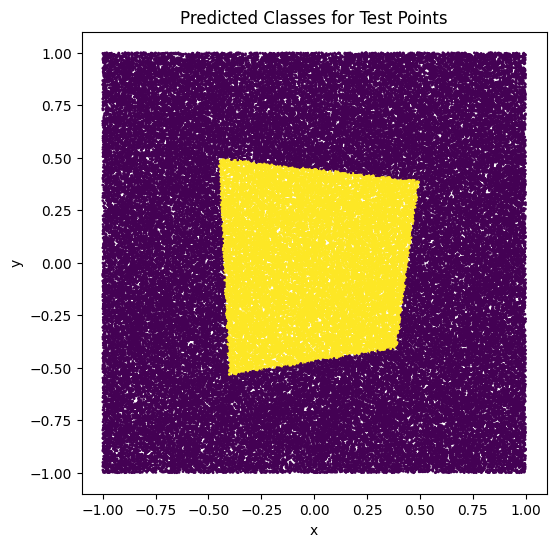

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Generate 10000 new points
n_points_test = 100000
points_test = np.random.uniform(-1, 1, (n_points_test, 2))
points_test_torch = torch.from_numpy(points_test).float()

# Run the points through the network
with torch.no_grad():  # We don't need gradients for this part
    tmp = points_test_torch@W1 + b1
    tmp = F.relu(tmp)
    output_test = tmp@W2 + b2

prob = torch.sigmoid(output_test)
pred = (0.5 < prob).numpy()

# Plot the points, colored by their predicted class
plt.figure(figsize=(6, 6))
plt.scatter(points_test[:, 0], points_test[:, 1], c=pred, cmap='viridis', s=1)
plt.title('Predicted Classes for Test Points')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
